# `Geoparquet` direct access example

**Authors:** Leo Ghignone, Denisse Fierro Arcos  
  
This notebook demonstrates direct access to a dataset in the RIMReP `geoparquet` collection. The `geoparquet` collection is a collection of datasets that have been converted to the Apache `parquet` format. This format is designed for efficient storage and retrieval of tabular data. The `geoparquet` collection is stored on the RIMReP S3 bucket and is accessible to all users.  
  
We will use the [AIMS Temperature Logger Monitoring Program](https://apps.aims.gov.au/metadata/view/4a12a8c0-c573-11dc-b99b-00008a07204e) dataset as an example. This dataset includes sea temperature data since 1980 for tropical and subtropical coral reefs around Australia, including sites within the Great Barrier Reef.  
  
The workflow in this notebook is as follows:
- Inspect dataset metadata
- Aggregate and plot temperature data for all sites where temperature loggers were deployed
- Collect data for a specific region, in this case we will use the Great Barrier Reef Marine Protected Area as our region of interest

## Loading libraries

In [1]:
# Accessing S3 bucket
from pyarrow import parquet as pq
# Manipulating dataframes
import pandas as pd
# Load and manipulate geospatial data
import dask_geopandas
import geopandas as gpd
# Spatial data
from shapely.geometry import Polygon
# Plotting
import matplotlib.pyplot as plt
# Mapping
import cartopy.crs as ccrs
import cartopy.feature as cf


## Inspecting metadata
The AIMS Temperature dataset contains over 150 million records. We will use its metadata to check the structure of the dataset and to determine the best way to access the data.

In [2]:
#Connecting to metadata file
md = pq.read_metadata(f"s3://rimrep-data-public/091-aims-sst/test-50-64-spatialpart/_metadata")
#Checking contents
md

  created_by: parquet-cpp-arrow version 10.0.1
  num_columns: 23
  num_rows: 150663521
  num_row_groups: 50
  format_version: 2.6
  serialized_size: 155051

The metadata is telling us that the AIMS temperature dataset contains 23 columns and over 150 million rows, and it is made up of 50 different files.  
  
We can check the structure of the data by calling its `schema` attribute. This will return a list containing the name of the column and its data type.

In [3]:
md.schema

required group field_id=-1 schema {
  optional int64 field_id=-1 fid;
  optional int64 field_id=-1 deployment_id;
  optional binary field_id=-1 site (String);
  optional int64 field_id=-1 site_id;
  optional binary field_id=-1 subsite (String);
  optional int64 field_id=-1 subsite_id;
  optional int64 field_id=-1 from_date (Timestamp(isAdjustedToUTC=false, timeUnit=microseconds, is_from_converted_type=false, force_set_converted_type=false));
  optional int64 field_id=-1 thru_date (Timestamp(isAdjustedToUTC=false, timeUnit=microseconds, is_from_converted_type=false, force_set_converted_type=false));
  optional double field_id=-1 depth;
  optional binary field_id=-1 parameter (String);
  optional binary field_id=-1 instrument_type (String);
  optional binary field_id=-1 serial_num (String);
  optional double field_id=-1 lat;
  optional double field_id=-1 lon;
  optional binary field_id=-1 gbrmpa_reef_id (String);
  optional binary field_id=-1 metadata_uuid (String);
  optional double fie

The `schema` tells us that the dataset contains 23 columns, which matches the information we got from the metadata. It also tells us that the data types are either `string` or `double`.  
  
We can also obtain more details about a specific column, by calling the `column` method and passing the name of the column as an argument as shown below.

In [15]:
md.schema.column(19)

<ParquetColumnSchema>
  name: qc_val
  path: qc_val
  max_definition_level: 1
  max_repetition_level: 0
  physical_type: DOUBLE
  logical_type: None
  converted_type (legacy): NONE

If we refer to the original site for the [AIMS Temperature Logger Monitoring Program](https://apps.aims.gov.au/metadata/view/4a12a8c0-c573-11dc-b99b-00008a07204e), we can see that the `qc_val` column refers to the quality controlled temperature obtained from the loggers deployed as part of this program.

## Connecting to S3 bucket and loading temperature logger deployment sites
Now that we have checked the structure of the dataset, we will connect to the RIMReP S3 bucket and load the dataset into memory. We will use the `dask_geopandas` library to connect to the S3 bucket and load the dataset into a `pandas` dataframe.  
  
First, we will load the temperature logger deployment sites from the `geoparquet` collection. We will use the following columns:  
- `site_id`: unique ID of the logger deployment site,
- `lat`: latitude of the logger deployment site,
- `lon`: longitude of the logger deployment site
    
We will only keep sites that have been deployed in the Great Barrier Reef Marine Protected Area (GBRMPA), so we will provide a `filter` that contains the minimum and maximum coordinates (i.e., `lat` and `lon`) of a bounding box around the Great Barrier Reef Marine Protected Area.

In [14]:
#Defining maximum and minimum coordinates for bounding box around the GBRMPA
filter = [('lon', '>=', 140.5),
          ('lat', '>=', -28.5),
          ('lon', '<=', 156.0),
          ('lat', '<=', -6.5)]

#Connecting to the S3 bucket where the AIMS temperature data is stored
dask_geo_df = dask_geopandas.read_parquet("s3://rimrep-data-public/091-aims-sst/test-50-64-spatialpart/", 
                                          #We specify the columns we want to read
                                          columns = ['site_id', 'lat', 'lon'],
                                          #We specify the filter we want to apply - which we specified at the beginning of this code chunk
                                          filters = [filter],
                                          #Connecting anonimously as no authentication is needed for this s3 bucket (it is public)
                                          storage_options = {"anon": True})  

#Checking the contents of the dataframe - First five rows
dask_geo_df.head()

,site_id,lat,lon
hilbert_distance,,,
2245686156,979,-17.4935,140.8302
2245686156,979,-17.4935,140.8302
2245686156,979,-17.4935,140.8302
2245686156,979,-17.4935,140.8302
2245686156,979,-17.4935,140.8302


You can see above that the `site_id` is repeated multiple times. This is because the temperature loggers were deployed on multiple occassions at the same site. If we print more rows, you will also see that the coordinates for a particular site vary slightly. This is because the temperature loggers were not deployed at the exact same location each time, but they were all deployed near each other.  
    
Next, we will calculate the mean deployment coordinate and total number of temperature records for each site. We will use the `groupby` method to group the data by `site_id` and then we will use the `agg` method to perform our calculations.  
  
Note the use of `compute()` at the end of our code. This will trigger our calculations and load the results as a data frame into memory.

In [15]:
#Grouping our dataframe by site_id and aggregating the lat and lon columns by mean and the site_id column by count
counts = dask_geo_df.groupby('site_id').agg(
    #Calculating mean lat and lon
    lat = pd.NamedAgg(column = 'lat', aggfunc = 'mean'),
    lon = pd.NamedAgg(column = 'lon', aggfunc = 'mean'),
    #Calculating the number of rows (i.e., deployments) per site_id
    number = pd.NamedAgg(column = 'site_id', aggfunc = 'count')).compute()

#Checking the contents of the dataframe - First five rows
counts.head()

,lat,lon,number
site_id,,,
979,-17.493500,140.8302,139636
910,-13.169053,143.5803,453962
3480,-12.585000,143.5112,321118
927,-12.670900,141.8665,113305
928,-12.678300,141.7883,12907


### Plotting the deployment sites
Now that we have the mean deployment coordinates for each site, we can plot them on a map. We will plot the data using markers which will change in size in proportion to the number of temperature records taken at each site.

c:\Users\ldfierro\AppData\Local\miniconda3\envs\rimrep\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


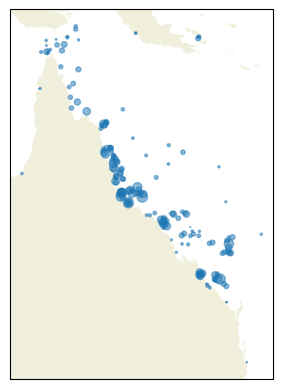

In [17]:
#Initiliasing the figure
fig = plt.figure()

#Adding a plot to the figure and assigning projection
ax = plt.axes(projection = ccrs.PlateCarree())

#Plotting the data using a scatter plot
ax.scatter(x = counts.lon, y = counts.lat, s = counts.number/50000, alpha = 0.5)

#Adding a basemap of land areas
ax.add_feature(cf.LAND)

## Connecting to S3 bucket and loading temperature data for a specific region
In the previous section we showed how to filter data using a bounding box. We provided a maximum and minimum coordinates for this bounding box around the GBRMPA. In this section, we will show how to filter data using a more complex shape. We will define a polygon for an area of interest and use this polygon to filter the temperature data.  
  
We will use the boundaries of the South-east of Great Palm Island as our area of interest. Note that each pair of coordinates represents a node along the polygon boundary. It should also be noted that the first and last coordinates must be the same as to close the polygon.

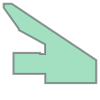

In [4]:
# Defining boundaries of the GBRMP zone MNP-18-1082 "South-east of Great Palm Island"
boundary = Polygon(
    [(146.551097906,-18.533297348),
    (146.995068388,-18.829679637),
    (146.995068388,-18.9503959749999),
    (146.741000438,-18.9503959749999),
    (146.726817846,-18.9503959749999),
    (146.726817846,-18.901664877),
    (146.559980192,-18.901664877),
    (146.559980192,-18.860043204),
    (146.559980192,-18.830003607),
    (146.559980192,-18.7916486789999),
    (146.699865007,-18.7916486789999),
    (146.699865007,-18.7975971989999),
    (146.725899924,-18.7975971989999),
    (146.725899924,-18.746824945),
    (146.725899924,-18.7468142619999),
    (146.725872512,-18.746799391),
    (146.587994956,-18.672003247),
    (146.587994956,-18.665847742),
    (146.508765289,-18.5543376589999),
    (146.508765289,-18.544419717),
    (146.508765289,-18.533297348),
    (146.551097906,-18.533297348)]
)

# Checking the variable we just created
boundary

Our polygon has been successfully defined as a `shapely` polygon. We can now use this polygon to filter the AIMS temperature data. We will use the `within` method to filter the data. This method will return `True` if the coordinates of a temperature record are within the polygon and `False` if they are not.

### Building a filter using polygon boundaries
Filtering the temperature data using the shape directly is possible, but not very inefficient. This why we will use a 2-step approach. First, we will filter the data using a bounding box as shown in the section above. Second, we will intersect the filtered data with the polygon we defined above.

In [5]:
# Getting the bounding box for the polygon defined above
minx, miny, maxx, maxy = boundary.bounds

# Building the filter using the bounding box
filter = [('lon', '>=', minx),
          ('lat', '>=', miny),
          ('lon', '<=', maxx),
          ('lat', '<=', maxy),
          #We will add another condition to our filter. We will only keep data with quality control flag 1
          ('qc_flag', '=', 1),
          #('time', '>=', pd.Timestamp('2002-07-20', tz="UTC"))
          #('time', '<', pd.Timestamp('2002-07-20', tz="UTC"))
          ]

### Applying filter to AIMS dataset using `pyarrow`
We will connect to the S3 bucket using `pyarrow`, but we will only load the columns of our interest:  
- `fid`: unique ID,
- `site`: name of deployment site,
- `qc_val`: quality controlled temperature,
- `geometry`: coordinates of logger deployment sites given in  [well-known binary (WKB)](https://loc.gov/preservation/digital/formats/fdd/fdd000549.shtml) format.

In [6]:
# Connecting to the S3 bucket where the AIMS temperature data is stored
ds = pq.ParquetDataset("s3://rimrep-data-public/091-aims-sst/test-50-64-spatialpart/", 
                       #Applying filter
                       filters = [filter]) 

The above code chunk creates a `Parquet Dataset` object that contains data from the AIMS temperature dataset that has been filtered using the bounding box we defined above. We can now choose which columns we want to read from this dataset: `fid`, `site`, `qc_val` and `geometry`. Finally, we can turn it into a `pandas` dataframe by calling the `to_pandas()` method as shown below.  
  
Note that this make take a few minutes depending on your internet connection. This is because we are querying over 150 million temperature records.

In [8]:
# The above give us access to all columns in the dataset. Here, we specify which columns we want to read
table = ds.read(['fid', 'site', 'qc_val', 'geometry']) 

# Converting to pandas dataframe
df = table.to_pandas()

# Checking the contents of the dataframe - First five rows
df.head()

,fid,site,qc_val,geometry
0,28085253,Orpheus Island,26.3531,b'\x01\x01\x00\x00\x00\x1e\x16jM\xf3Vb@=\n\xd7...
1,28085252,Orpheus Island,26.3232,b'\x01\x01\x00\x00\x00\x1e\x16jM\xf3Vb@=\n\xd7...
2,28085251,Orpheus Island,26.3034,b'\x01\x01\x00\x00\x00\x1e\x16jM\xf3Vb@=\n\xd7...
3,28085250,Orpheus Island,26.2934,b'\x01\x01\x00\x00\x00\x1e\x16jM\xf3Vb@=\n\xd7...
4,28085249,Orpheus Island,26.2636,b'\x01\x01\x00\x00\x00\x1e\x16jM\xf3Vb@=\n\xd7...


### Transforming `geometry` column from WKB format to coordinates
As we can see above, the `geometry` column is not very useful in its current format (WKB). In this section, we will transform the information in this column to a `geopandas` object, which contains latitude and longitude coordinates that we can use to apply our polygon filter, and to plot the filtered `data in a map.

In [10]:
# Transforming the geometry column into a geopandas geometry object
geom = gpd.GeoSeries.from_wkb(df['geometry'])

# Replacing the original geometry column in WKB format with the new geometry object containing lat and lon coordinates, and changing to a geopandas dataframe
gdf = gpd.GeoDataFrame(df, geometry = geom)

#Checking results
gdf

,fid,site,qc_val,geometry
0,28085253,Orpheus Island,26.3531,POINT (146.71720 -18.80250)
1,28085252,Orpheus Island,26.3232,POINT (146.71720 -18.80250)
2,28085251,Orpheus Island,26.3034,POINT (146.71720 -18.80250)
3,28085250,Orpheus Island,26.2934,POINT (146.71720 -18.80250)
4,28085249,Orpheus Island,26.2636,POINT (146.71720 -18.80250)
...,...,...,...,...
983715,44619517,Havannah Island,24.9381,POINT (146.54270 -18.84750)
983716,44619513,Havannah Island,24.9581,POINT (146.54270 -18.84750)
983717,44619520,Havannah Island,24.9281,POINT (146.54270 -18.84750)
983718,44619519,Havannah Island,24.9281,POINT (146.54270 -18.84750)


### Applying polygon filter to temperature data
Now that we have transformed the `geometry` column into a `geopandas` object, we can apply our polygon filter. We will use the `within` method to filter the data.

In [11]:
# Intersecting filtered temperature data with the polygon created at the beginning of this section
gdf = gdf[gdf['geometry'].within(boundary)]

#Checking results
gdf

,fid,site,qc_val,geometry
0,28085253,Orpheus Island,26.3531,POINT (146.71720 -18.80250)
1,28085252,Orpheus Island,26.3232,POINT (146.71720 -18.80250)
2,28085251,Orpheus Island,26.3034,POINT (146.71720 -18.80250)
3,28085250,Orpheus Island,26.2934,POINT (146.71720 -18.80250)
4,28085249,Orpheus Island,26.2636,POINT (146.71720 -18.80250)
...,...,...,...,...
50547,27760270,Orpheus Island,28.6604,POINT (146.71720 -18.80250)
50548,27760267,Orpheus Island,28.6902,POINT (146.71720 -18.80250)
50549,27762279,Orpheus Island,28.6703,POINT (146.71720 -18.80250)
50550,27760269,Orpheus Island,28.6703,POINT (146.71720 -18.80250)


By applying this polygon filter, the number of rows were reduced from almost one million records to just over 50,500 records. We can now plot the filtered data on a map.

### Plotting map of filtered data

(146.008765289, 147.495068388)

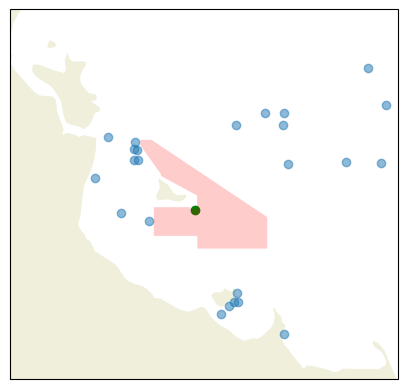

In [40]:
#Initiliasing the figure
fig = plt.figure()

#Adding a plot to the figure and assigning projection
ax = plt.axes(projection = ccrs.PlateCarree())

#Plotting the mean location for all deployment sites 
ax.scatter(x = counts.lon, y = counts.lat, alpha = 0.5)

#Plotting the unqiue location filtered temperature data
gpd.GeoSeries(pd.unique(gdf.geometry)).plot(color = 'green', ax = ax)

#Plotting the boundary of the GBRMP zone MNP-18-1082 "South-east of Great Palm Island"
gpd.GeoSeries(boundary).plot(ax = ax, color = 'red', alpha=0.2)

#Adding a basemap of land areas
ax.add_feature(cf.LAND)

#Changing the limits of the plot to zoom in on the GBRMP zone MNP-18-1082 "South-east of Great Palm Island"
plt.ylim([miny-0.5, maxy+0.5])
plt.xlim([minx-0.5, maxx+0.5])

## Accessing S3 bucket and filtering data using `dask_geopandas`
We can use geopandas directly to extract the data from the S3 bucket. This section offers a different approach to the section before, but the results are the same.

In [41]:
# Connecting to S3 bucket
dask_geo_df = dask_geopandas.read_parquet("s3://rimrep-data-public/091-aims-sst/test-50-64-spatialpart/", 
                                          #Applying initial bounding box filter
                                          filters = [filter], 
                                          #Specifying which columns to read
                                          columns = ['site', 'time', 'qc_val', 'geometry'],
                                          #Specifying the column to be used as index
                                          index = 'fid',
                                          #Connecting anonimously as no authentication is needed for this s3 bucket (it is public)
                                          storage_options = {"anon": True}) 

We have established the connection to the S3 bucket and applied the initial bounding box filter. Now, we will filter the data further by applying the polygon filter by applying the `within` method to the `geometry` column. We will then apply the `compute()` method to load the filtered data into memory.

In [42]:
# Intersecting filtered data with geometry boundaries
dask_geo_df = dask_geo_df[dask_geo_df['geometry'].within(boundary)]

# Do the computation!
gdf = dask_geo_df.compute()

#Check results
gdf.head()

,site,time,qc_val,geometry
fid,,,,
28085253,Orpheus Island,2012-05-06 03:21:47+00:00,26.3531,POINT (146.71720 -18.80250)
28085252,Orpheus Island,2012-05-06 03:11:47+00:00,26.3232,POINT (146.71720 -18.80250)
28085251,Orpheus Island,2012-05-06 03:01:47+00:00,26.3034,POINT (146.71720 -18.80250)
28085250,Orpheus Island,2012-05-06 02:51:47+00:00,26.2934,POINT (146.71720 -18.80250)
28085249,Orpheus Island,2012-05-06 02:41:47+00:00,26.2636,POINT (146.71720 -18.80250)


### Plotting map of filtered data
This map should be exactly the same as the previous map because both data filtering methods are equivalent and produce the same results.

(146.008765289, 147.495068388)

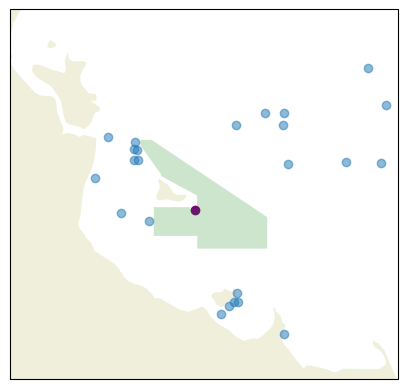

In [47]:
#Initiliasing the figure
fig = plt.figure()

#Adding a plot to the figure and assigning projection
ax = plt.axes(projection = ccrs.PlateCarree())

#Plotting the mean location for all deployment sites 
ax.scatter(x = counts.lon, y = counts.lat, alpha = 0.5)

#Plotting the unqiue location filtered temperature data
gpd.GeoSeries(pd.unique(gdf.geometry)).plot(color = 'purple', ax = ax)

#Plotting the boundary of the GBRMP zone MNP-18-1082 "South-east of Great Palm Island"
gpd.GeoSeries(boundary).plot(ax = ax, color = 'green', alpha=0.2)

#Adding a basemap of land areas
ax.add_feature(cf.LAND)

#Changing the limits of the plot to zoom in on the GBRMP zone MNP-18-1082 "South-east of Great Palm Island"
plt.ylim([miny-0.5, maxy+0.5])
plt.xlim([minx-0.5, maxx+0.5])

### Plotting time series of filtered data
We selected the time column to be included in the data we extracted using `dask_geopandas`, so we will use this information to plot a time series of the filtered data.

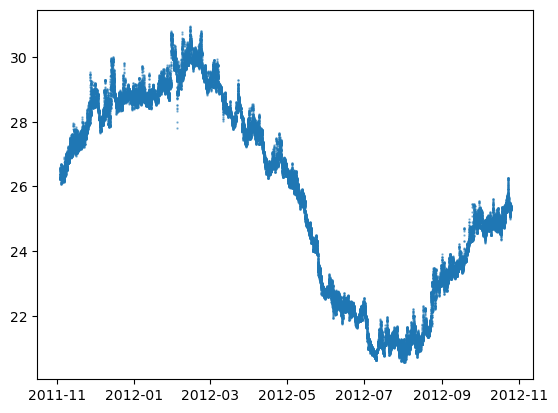

In [52]:
#Initiliasing the figure
fig = plt.figure()

#Adding a plot to the figure
ax = plt.axes()

#Plotting the temperature data across time at the filtered location
ax.scatter(x = gdf.time, y = gdf.qc_val, alpha = 0.5, s = 0.5)